In [22]:
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd

# Initial state
state = {
    'amount_staked': 100000,
    'stakeholders': 500,
    'rewards': 40000 # emissions
}

# Simulation parameters
params = {
    'stake_rate': [1,2,3],  # rate at which new stakes are added
    'unstake_rate': [0.5,0.75,1],  # rate at which stakes are removed
    'reward_rate': [0.1,0.2,0.3]  # rate at which rewards are given
}


def policy_add_stake(params, step, history, current_state):
    # Stakeholders are more likely to add stakes when rewards are high
    reward_multiplier = current_state['rewards'] / 1000
    # Stakeholders are less likely to add stakes over time
    time_multiplier = 1 - current_state['timestep'] / 10000
    # The base rate at which stakes are added is a random value
    base_rate = np.random.poisson(params['stake_rate'])
    # The actual amount added is the base rate modified by the reward and time multipliers
    amount = base_rate * reward_multiplier * time_multiplier
    return {'add_stake': amount}



def policy_remove_stake(params, step, history, current_state):
    # Stakeholders are more likely to remove stakes when rewards are low
    reward_multiplier = 1 - current_state['rewards'] / 1000
    # Stakeholders are more likely to remove stakes over time
    time_multiplier = current_state['timestep'] / 10000
    # The base rate at which stakes are removed is a random value
    base_rate = np.random.poisson(params['unstake_rate'])
    # The actual amount removed is the base rate modified by the reward and time multipliers
    amount = base_rate * reward_multiplier * time_multiplier
    return {'remove_stake': amount}

def policy_claim_reward(params, step, history, current_state):
    # Stakeholders are more likely to claim rewards when they have a lot staked
    stake_multiplier = current_state['amount_staked'] / 1000
    # Stakeholders are more likely to claim rewards over time
    time_multiplier = current_state['timestep'] / 10000
    # The base rate at which rewards are claimed is a random value
    base_rate = np.random.poisson(params['reward_rate'])
    # The actual amount claimed is the base rate modified by the stake and time multipliers
    amount = base_rate * stake_multiplier * time_multiplier
    return {'claim_reward': amount}


# State update functions
def update_amount_staked(params, step, history, current_state, input_):
    amount_staked = current_state['amount_staked'] + input_['add_stake'] - input_['remove_stake']
    return ('amount_staked', max(amount_staked, 0))

def update_stakeholders(params, step, history, current_state, input_):
    stakeholders = current_state['stakeholders'] + int(input_['add_stake'] > 0) - int(input_['remove_stake'] > 0)
    return ('stakeholders', max(stakeholders, 0))

def update_rewards(params, step, history, current_state, input_):
    rewards = current_state['rewards'] + input_['claim_reward']
    return ('rewards', max(rewards, 0))

# Partial state update blocks
partial_state_update_blocks = [
    {
        'policies': {
            'add_stake': policy_add_stake,
            'remove_stake': policy_remove_stake,
        },
        'variables': {
            'amount_staked': update_amount_staked,
            'stakeholders': update_stakeholders,
        }
    },
    {
        'policies': {
            'claim_reward': policy_claim_reward
        },
        'variables': {
            'rewards': update_rewards
        }
    }
]


# Simulation parameters
sim_config = {
    'N': 1,  # number of Monte Carlo runs
    'T': range(1000),  # number of timesteps
    'M': params  # model parameters
}

sim_params = config_sim(sim_config)

# Configuring and running the simulation
exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 3, 3, 3)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 3, 3, 3)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 7.09s


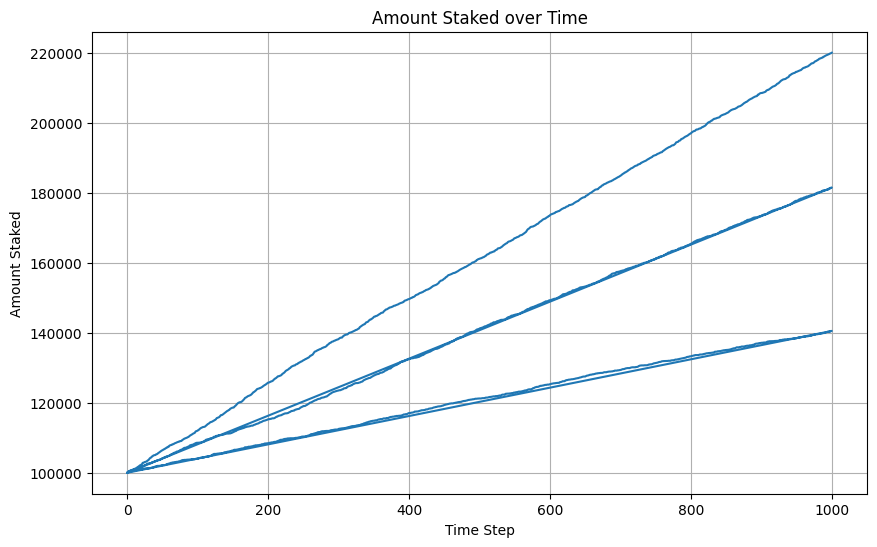

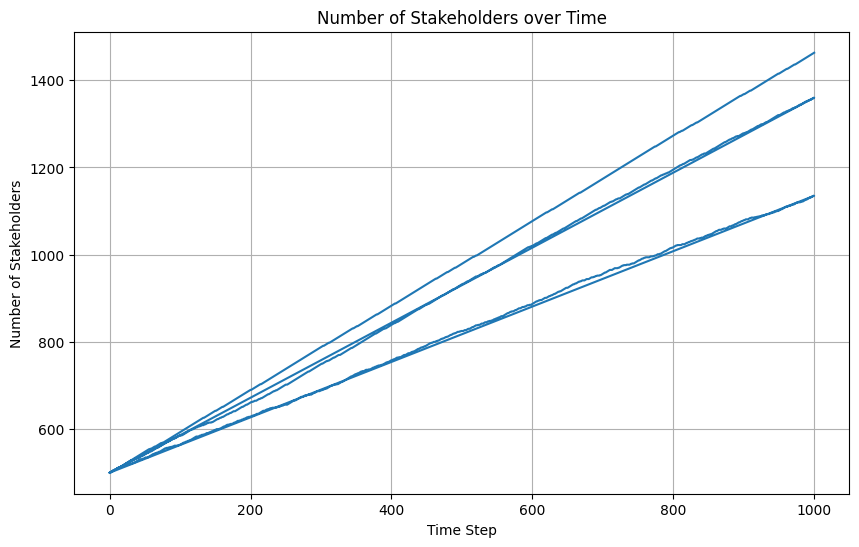

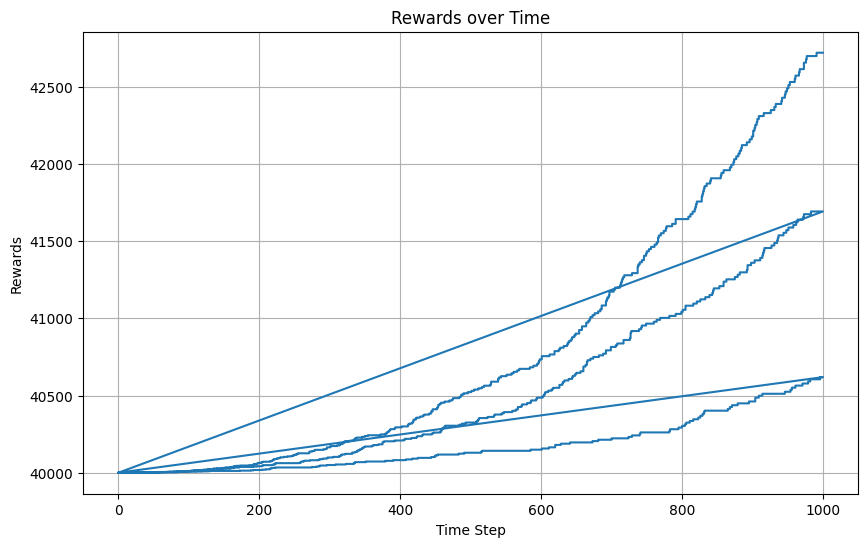

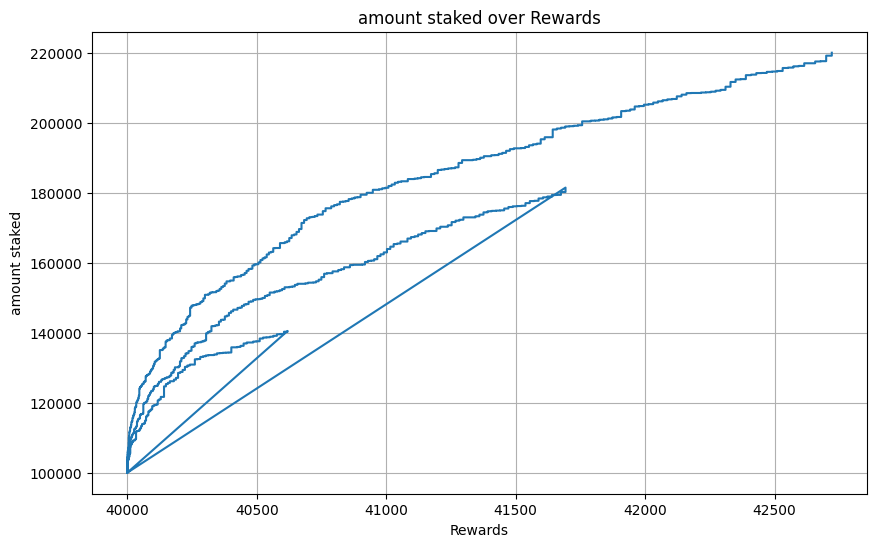

In [24]:
import matplotlib.pyplot as plt

# Plot the amount staked over time
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['amount_staked'])
plt.xlabel('Time Step')
plt.ylabel('Amount Staked')
plt.title('Amount Staked over Time')
plt.grid(True)
plt.show()

# Plot the number of stakeholders over time
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['stakeholders'])
plt.xlabel('Time Step')
plt.ylabel('Number of Stakeholders')
plt.title('Number of Stakeholders over Time')
plt.grid(True)
plt.show()

# Plot the rewards over time
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['rewards'])
plt.xlabel('Time Step')
plt.ylabel('Rewards')
plt.title('Rewards over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df['rewards'],df['amount_staked'] )
plt.xlabel('Rewards')
plt.ylabel('amount staked')
plt.title('amount staked over Rewards')
plt.grid(True)
plt.show()

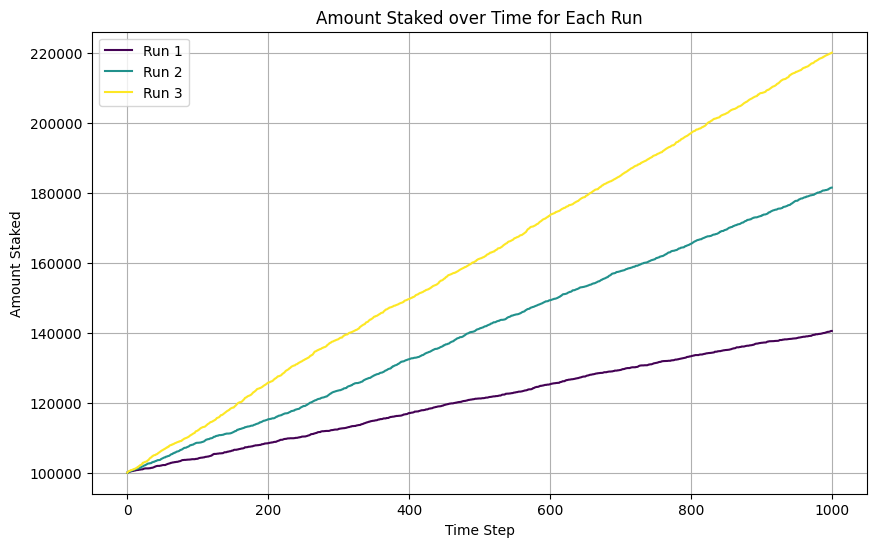

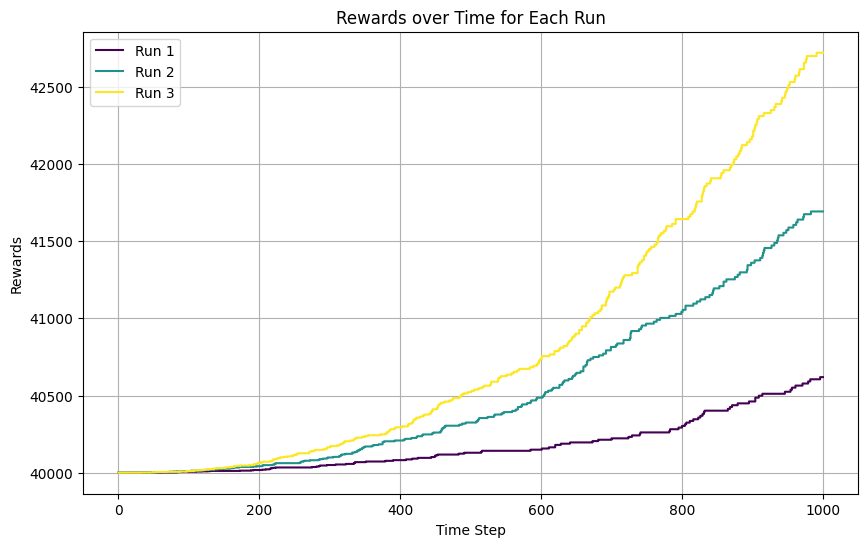

In [25]:
runs = df['run'].unique()  # get all unique runs

# Create a color map for the runs
colors = plt.cm.viridis(np.linspace(0, 1, len(runs)))

# Plot the amount staked over time for each run
plt.figure(figsize=(10, 6))
for i, run in enumerate(runs):
    plt.plot(df[df['run'] == run]['timestep'], df[df['run'] == run]['amount_staked'], color=colors[i], label=f'Run {run}')
plt.xlabel('Time Step')
plt.ylabel('Amount Staked')
plt.title('Amount Staked over Time for Each Run')
plt.legend()
plt.grid(True)
plt.show()

# Do the same for the number of stakeholders and the rewards
runs = df['run'].unique()  # get all unique runs

# Create a color map for the runs
colors = plt.cm.viridis(np.linspace(0, 1, len(runs)))

# Plot the amount staked over time for each run
plt.figure(figsize=(10, 6))
for i, run in enumerate(runs):
    plt.plot(df[df['run'] == run]['timestep'], df[df['run'] == run]['rewards'], color=colors[i], label=f'Run {run}')
plt.xlabel('Time Step')
plt.ylabel('Rewards')
plt.title('Rewards over Time for Each Run')
plt.legend()
plt.grid(True)
plt.show()

# Do the same for the number of stakeholders and the rewards



In [8]:
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd

# Initial state
state = {
    'amount_staked': 100000,
    'stakeholders': 500,
    'rewards': 40000,
    'token_price': 1.0  # initial token price
}

# Simulation parameters
params = {
    'stake_rate': [1],  # rate at which new stakes are added
    'unstake_rate': [0.5],  # rate at which stakes are removed
    'reward_rate': [0.1,0.2,0.3],  # rate at which rewards are given
    'price_change_rate': [0.05]  # token price can decrease, stay the same, or increase
}

def policy_add_stake(params, step, history, current_state):
    reward_multiplier = current_state['rewards'] / 1000
    time_multiplier = 1 - current_state['timestep'] / 10000
    price_multiplier = current_state['token_price']
    base_rate = np.random.poisson(params['stake_rate'])
    amount = base_rate * reward_multiplier * time_multiplier * price_multiplier
    return {'add_stake': amount}

def policy_remove_stake(params, step, history, current_state):
    reward_multiplier = 1 - current_state['rewards'] / 1000
    time_multiplier = current_state['timestep'] / 10000
    price_multiplier = 1 / current_state['token_price']
    base_rate = np.random.poisson(params['unstake_rate'])
    amount = base_rate * reward_multiplier * time_multiplier * price_multiplier
    return {'remove_stake': amount}

def policy_claim_reward(params, step, history, current_state):
    stake_multiplier = current_state['amount_staked'] / 1000
    time_multiplier = current_state['timestep'] / 10000
    base_rate = np.random.poisson(params['reward_rate'])
    amount = base_rate * stake_multiplier * time_multiplier
    return {'claim_reward': amount}

def policy_price_change(params, step, history, current_state):
    price_change = params['price_change_rate']*current_state['token_price']
    return {'price_change': price_change}

def update_amount_staked(params, step, history, current_state, input_):
    amount_staked = current_state['amount_staked'] + input_['add_stake'] - input_['remove_stake']
    return ('amount_staked', max(amount_staked, 0))

def update_stakeholders(params, step, history, current_state, input_):
    stakeholders = current_state['stakeholders'] + int(input_['add_stake'] > 0) - int(input_['remove_stake'] > 0)
    return ('stakeholders', max(stakeholders, 0))

def update_rewards(params, step, history, current_state, input_):
    stake_proportion = current_state['amount_staked'] / 1000
    rewards = current_state['rewards'] - input_['claim_reward'] * stake_proportion
    return ('rewards', max(rewards, 0))

def update_token_price(params, step, history, current_state, input_):
    token_price = current_state['token_price'] + input_['price_change']
    return ('token_price', max(token_price, 0))

partial_state_update_blocks = [
    {
        'policies': {
            'add_stake': policy_add_stake,
            'remove_stake': policy_remove_stake,
            'price_change': policy_price_change
        },
        'variables': {
            'amount_staked': update_amount_staked,
            'stakeholders': update_stakeholders,
            'token_price': update_token_price
        }
    },
    {
        'policies': {
            'claim_reward': policy_claim_reward
        },
        'variables': {
            'rewards': update_rewards
        }
    }
]

sim_config = {
    'N': 1,  # number of Monte Carlo runs
    'T': range(1000),  # number of timesteps
    'M': params  # model parameters
}

sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)
df.head()




                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 4, 3, 4)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 4, 3, 4)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 5.02s


,amount_staked,stakeholders,rewards,token_price,simulation,subset,run,substep,timestep
0,100000.0000,500,40000.0,1.0000,0,0,1,0,0
1,100040.0000,501,40000.0,1.0500,0,0,1,1,1
2,100040.0000,501,40000.0,1.0500,0,0,1,2,1
3,100123.9916,502,40000.0,1.1025,0,0,1,1,2
4,100123.9916,502,40000.0,1.1025,0,0,1,2,2


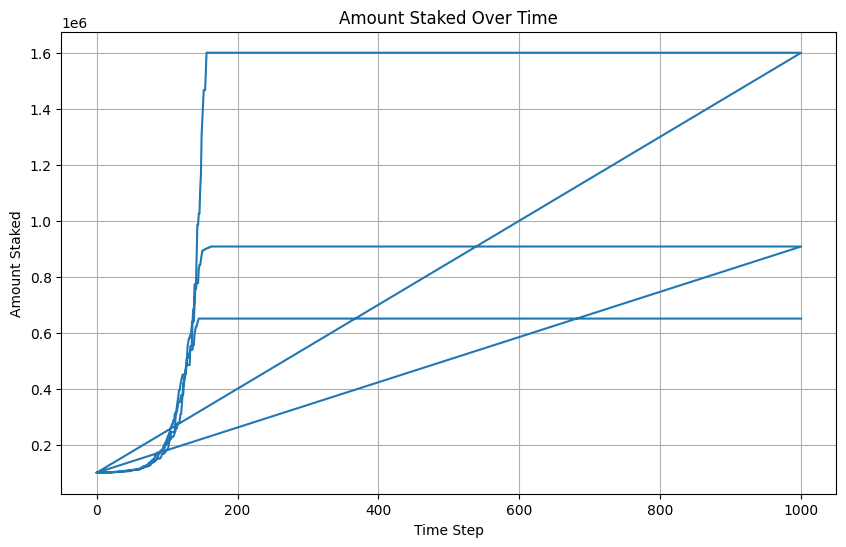

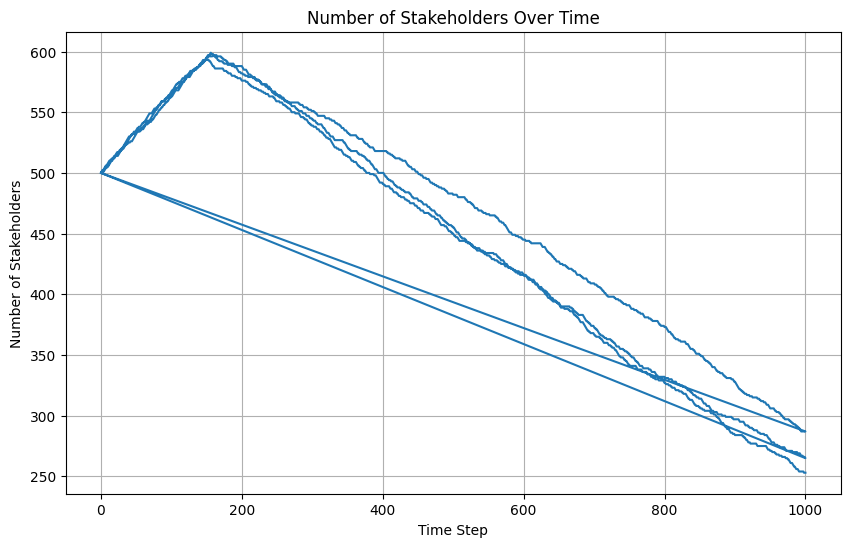

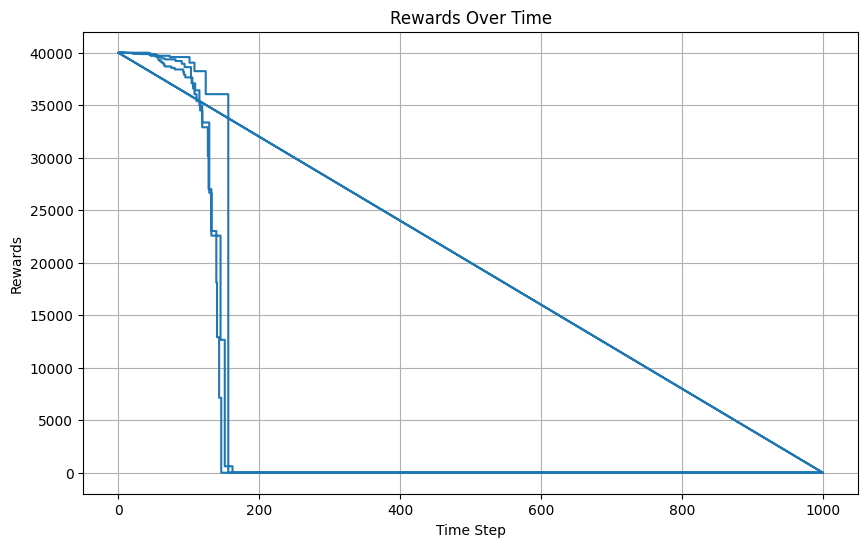

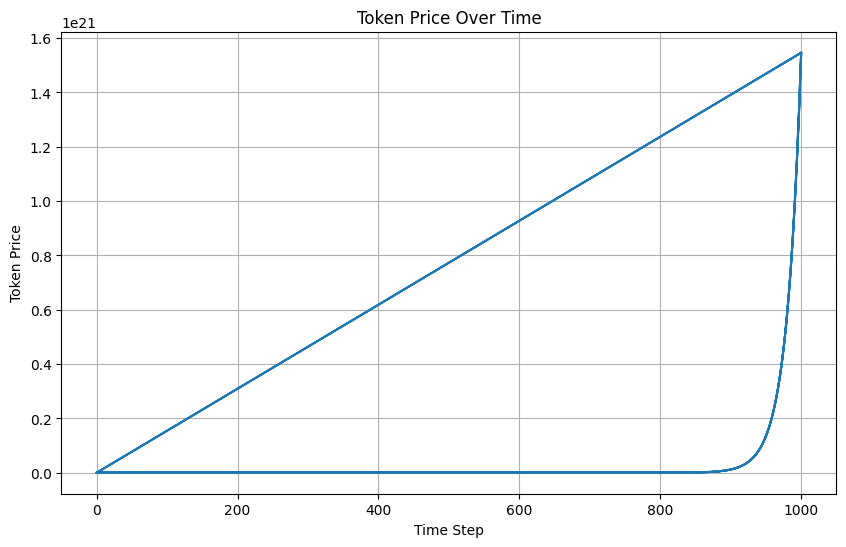

In [9]:
import matplotlib.pyplot as plt
import helper_functions

# Plotting the amount staked over time
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['amount_staked'])
plt.title('Amount Staked Over Time')
plt.xlabel('Time Step')
plt.ylabel('Amount Staked')
plt.grid(True)
plt.show()

# Plotting the number of stakeholders over time
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['stakeholders'])
plt.title('Number of Stakeholders Over Time')
plt.xlabel('Time Step')
plt.ylabel('Number of Stakeholders')
plt.grid(True)
plt.show()

# Plotting the rewards over time
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['rewards'])
plt.title('Rewards Over Time')
plt.xlabel('Time Step')
plt.ylabel('Rewards')
plt.grid(True)
plt.show()

# Plotting the token price over time
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['token_price'])
plt.title('Token Price Over Time')
plt.xlabel('Time Step')
plt.ylabel('Token Price')
plt.grid(True)
plt.show()
